## Correlation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

## Read Data

In [2]:
data = pd.read_csv('../Kyoto_Train.csv')
data.shape

(124055, 24)

### Train - Test Split

In [3]:
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['Label_code'], axis=1),
    data['Label_code'],
    test_size=0.2,
    random_state=0)

X_train.shape, X_test.shape

((99244, 23), (24811, 23))

## Correlation heatmap

<AxesSubplot:>

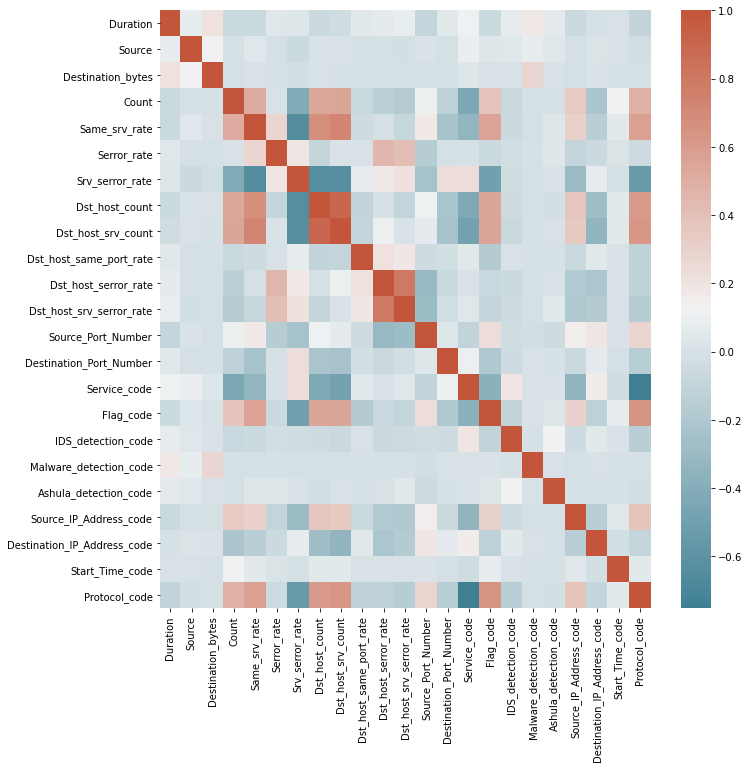

In [4]:
corrmat = X_train.corr(method='pearson')
cmap = sns.diverging_palette(220, 20, as_cmap=True)
fig, ax = plt.subplots()
fig.set_size_inches(11,11)
sns.heatmap(corrmat, cmap=cmap)

In the plot above, the dark orange squares correspond to highly correlated features (>0.8). Darker blue squares corresponds to negatively correlated features (<-0.8).

The diagonal represents the correlation of a feature with itself, therefore the value is 1.

We can see that there are a few features that are highly correlated.

In [6]:
X_test.columns

Index(['Duration', 'Source', 'Destination_bytes', 'Count', 'Same_srv_rate',
       'Serror_rate', 'Srv_serror_rate', 'Dst_host_count',
       'Dst_host_srv_count', 'Dst_host_same_port_rate', 'Dst_host_serror_rate',
       'Dst_host_srv_serror_rate', 'Source_Port_Number',
       'Destination_Port_Number', 'Service_code', 'Flag_code',
       'IDS_detection_code', 'Malware_detection_code', 'Ashula_detection_code',
       'Source_IP_Address_code', 'Destination_IP_Address_code',
       'Start_Time_code', 'Protocol_code'],
      dtype='object')

## Correlation scatterplots

In [7]:
c = 0
for i in corrmat.loc['Dst_host_count']:
    if i > 0.8:
        print(corrmat.columns[c], i)
    c = c + 1

Dst_host_count 1.0
Dst_host_srv_count 0.9035412214399879


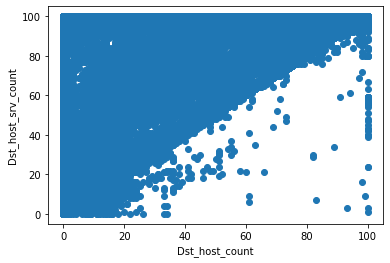

In [8]:
plt.scatter(X_train['Dst_host_count'], X_train['Dst_host_srv_count'])
plt.ylabel('Dst_host_srv_count')
plt.xlabel('Dst_host_count')
plt.show()

In [10]:
c = 0
for i in corrmat.loc['Dst_host_serror_rate']:
    if i > 0.8:
        print(corrmat.columns[c], i)
    c = c + 1

Dst_host_serror_rate 1.0
Dst_host_srv_serror_rate 0.8013587475372687


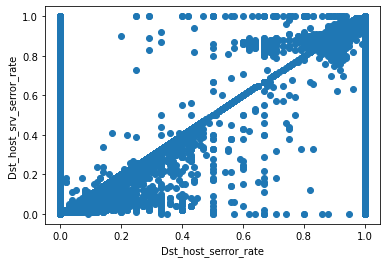

In [11]:
# now, let's plot the variables

plt.scatter(X_train['Dst_host_serror_rate'], X_train['Dst_host_srv_serror_rate'])
plt.ylabel('Dst_host_srv_serror_rate')
plt.xlabel('Dst_host_serror_rate')
plt.show()

We see that the correlation of the second pair of variables is not quite linear.

Next, let's identify a couple of negatively correlated variables:

In [12]:
c = 0
for i in corrmat.loc['Srv_serror_rate']:
    if i <- 0.6:
        print(corrmat.columns[c], i)
        
    c = c + 1

Same_srv_rate -0.6479025461808927
Dst_host_count -0.6434711036672625
Dst_host_srv_count -0.6340531043734371


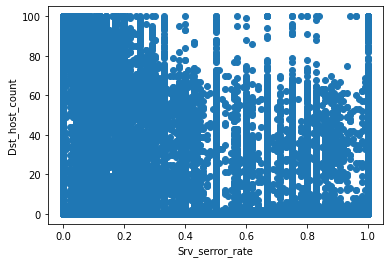

In [13]:
# now, let's plot the variables

plt.scatter(X_train['Srv_serror_rate'], X_train['Dst_host_count'])
plt.ylabel('Dst_host_count')
plt.xlabel('Srv_serror_rate')
plt.show()

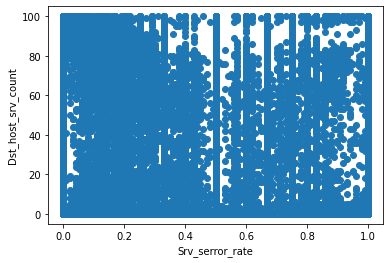

In [14]:
plt.scatter(X_train['Srv_serror_rate'], X_train['Dst_host_srv_count'])
plt.ylabel('Dst_host_srv_count')
plt.xlabel('Srv_serror_rate')
plt.show()

## Remove correlated

### Brute force approach

In [15]:
def correlation(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr()

    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                print(abs(corr_matrix.iloc[i, j]), corr_matrix.columns[i], corr_matrix.columns[j])
                colname = corr_matrix.columns[j]
                col_corr.add(colname)
    return col_corr

In [16]:
corr_features = correlation(X_train, 0.8)
len(set(corr_features))

0.9035412214399879 Dst_host_srv_count Dst_host_count
0.8013587475372687 Dst_host_srv_serror_rate Dst_host_serror_rate


2

We can see that 2 features are highly correlated with other features in the training set. 

Very likely, by removing these correlated features, the performance of your machine learning models will drop very little, if at all. We can go ahead and drop the features like we have done in previous methods.

In [17]:
corr_features

{'Dst_host_count', 'Dst_host_serror_rate'}

In [18]:
X_train.drop(labels=corr_features, axis=1, inplace=True)
X_test.drop(labels=corr_features, axis=1, inplace=True)

X_train.shape, X_test.shape

((99244, 21), (24811, 21))

By removing correlated columns we reduced the feature space from 23 numerical columns to 21.

### Second approach

The second approach looks to identify groups of highly correlated features. And then, we can make further investigation within these groups to decide which feature we keep and which one we remove.

In [19]:
data = pd.read_csv('../Kyoto_Train.csv')
data.shape

(124055, 24)

In [20]:
# separate train and test sets

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['Label_code'], axis=1),
    data['Label_code'],
    test_size=0.2,
    random_state=0)

X_train.shape, X_test.shape

((99244, 23), (24811, 23))

In [21]:
corrmat = X_train.corr()
corrmat = corrmat.abs().unstack() # absolute value of corr coef
corrmat = corrmat.sort_values(ascending=False)
corrmat = corrmat[corrmat >= 0.8]
corrmat = corrmat[corrmat < 1]
corrmat = pd.DataFrame(corrmat).reset_index()
corrmat.columns = ['feature1', 'feature2', 'corr']
corrmat.head()

,feature1,feature2,corr
0,Dst_host_count,Dst_host_srv_count,0.903541
1,Dst_host_srv_count,Dst_host_count,0.903541
2,Dst_host_serror_rate,Dst_host_srv_serror_rate,0.801359
3,Dst_host_srv_serror_rate,Dst_host_serror_rate,0.801359


In [22]:
grouped_feature_ls = []
correlated_groups = []

for feature in corrmat.feature1.unique():
    
    if feature not in grouped_feature_ls:

        correlated_block = corrmat[corrmat.feature1 == feature]
        grouped_feature_ls = grouped_feature_ls + list(
            correlated_block.feature2.unique()) + [feature]

        correlated_groups.append(correlated_block)

print('found {} correlated groups'.format(len(correlated_groups)))
print('out of {} total features'.format(X_train.shape[1]))

found 2 correlated groups
out of 23 total features


In [23]:
for group in correlated_groups:
    print(group)
    print()

         feature1            feature2      corr
0  Dst_host_count  Dst_host_srv_count  0.903541

               feature1                  feature2      corr
2  Dst_host_serror_rate  Dst_host_srv_serror_rate  0.801359



In [24]:
group = correlated_groups[1]
group

,feature1,feature2,corr
2,Dst_host_serror_rate,Dst_host_srv_serror_rate,0.801359


Alternatively, we could build a **machine learning algorithm using all the features from the above list, and select the more predictive one**.

In [29]:
from sklearn.ensemble import RandomForestClassifier

# add all features of the group to a list
features = list(group['feature2'].unique())+['Dst_host_srv_serror_rate']

# train a random forest 
rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=4)
rf.fit(X_train[features].fillna(0), y_train)

RandomForestClassifier(max_depth=4, n_estimators=200, random_state=39)

In [30]:
# get the feature importance attributed by the random forest model

importance = pd.concat(
    [pd.Series(features),
     pd.Series(rf.feature_importances_)], axis=1)

importance.columns = ['feature', 'importance']

# sort features by importance, most important first
importance.sort_values(by='importance', ascending=False)

,feature,importance
1,Dst_host_srv_serror_rate,0.504324
0,Dst_host_srv_serror_rate,0.495676


In this case, feature dst_host_srv_serror_rate shows the highest importance according to random forests. Then, I would select Dst_host_serror_rate, and remove all the remaining features from this group from the dataset.

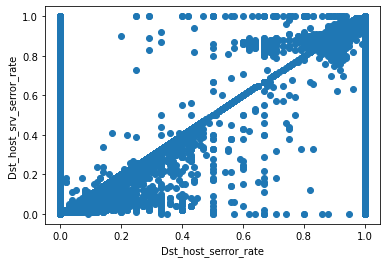

In [31]:
# Plot the correlation of the features in the correlated group from the previous cell

for feature in group['feature2']:
    plt.scatter(X_train['Dst_host_serror_rate'], X_train[feature])
    plt.xlabel('Dst_host_serror_rate')
    plt.ylabel(feature)
    plt.show()

## Read Data

In [33]:
data = pd.read_csv('../Kyoto_Train.csv')
data.shape

(124055, 24)

In [34]:
# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['Label_code','Dst_host_count','Dst_host_serror_rate'],
                       axis=1),         # drop the target and features
    data['Label_code'],               # just the target
    test_size=0.2,
    random_state=0)

X_train.shape, X_test.shape

((99244, 21), (24811, 21))

## Standardize Data

In [35]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

## Classifiers

In [36]:
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier

## Metrics Evaluation

In [37]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, f1_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score

### Logistic Regression

In [38]:
%%time
clf_LR = linear_model.LogisticRegression(n_jobs=-1, random_state=42, C=1).fit(X_train, y_train)

CPU times: user 74.8 ms, sys: 179 ms, total: 253 ms
Wall time: 2.93 s


In [39]:
pred_y_test = clf_LR.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_y_test))

f1 = f1_score(y_test, pred_y_test)
print('F1 Score:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_test)
print('FPR:', fpr[1])
print('TPR:', tpr[1])

Accuracy: 0.8455926806658337
F1 Score: 0.024942733519979637
FPR: 0.0687399893219434
TPR: 0.020985010706638114


### Naive Bayes

In [40]:
%%time
clf_NB = GaussianNB(var_smoothing=1e-05).fit(X_train, y_train)

CPU times: user 39.1 ms, sys: 7.66 ms, total: 46.8 ms
Wall time: 44.8 ms


In [41]:
pred_y_testNB = clf_NB.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_y_testNB))

f1 = f1_score(y_test, pred_y_testNB)
print('F1 Score:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_testNB)
print('FPR:', fpr[1])
print('TPR:', tpr[1])

Accuracy: 0.9045584619725122
F1 Score: 0.0
FPR: 0.0014682327816337426
TPR: 0.0


### Random Forest

In [42]:
%%time
clf_RF = RandomForestClassifier(random_state=0,max_depth=70,n_estimators=100).fit(X_train, y_train)

CPU times: user 6.37 s, sys: 61.7 ms, total: 6.43 s
Wall time: 6.45 s


In [43]:
pred_y_testRF = clf_RF.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_y_testRF))

f1 = f1_score(y_test, pred_y_testRF, average='weighted', zero_division=0)
print('F1 Score:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_testRF)
print('FPR:', fpr[1])
print('TPR:', tpr[1])

Accuracy: 0.9058885171899561
F1 Score: 0.8611563563923045
FPR: 1.0
TPR: 1.0


### KNN

In [44]:
%%time
clf_KNN = KNeighborsClassifier(algorithm='auto',leaf_size=1,n_neighbors=2,weights='uniform').fit(X_train, y_train)

CPU times: user 9.69 s, sys: 44.7 ms, total: 9.74 s
Wall time: 9.72 s


In [45]:
pred_y_testKNN = clf_KNN.predict(X_test)
print('accuracy_score:', accuracy_score(y_test, pred_y_testKNN))

f1 = f1_score(y_test, pred_y_testKNN)
print('f1:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_testKNN)
print('fpr:', fpr[1])
print('tpr:', tpr[1])

accuracy_score: 0.9058885171899561
f1: 0.0
fpr: 1.0
tpr: 1.0


### CatBoost

In [46]:
%%time
clf_CB = CatBoostClassifier(random_state=0,depth=7,iterations=50,learning_rate=0.04).fit(X_train, y_train)

0:	learn: 0.5361471	total: 77.5ms	remaining: 3.8s
1:	learn: 0.4665080	total: 94.7ms	remaining: 2.27s
2:	learn: 0.3614174	total: 112ms	remaining: 1.76s
3:	learn: 0.3175376	total: 129ms	remaining: 1.49s
4:	learn: 0.2683221	total: 147ms	remaining: 1.33s
5:	learn: 0.2308677	total: 166ms	remaining: 1.22s
6:	learn: 0.1873845	total: 183ms	remaining: 1.13s
7:	learn: 0.1412961	total: 201ms	remaining: 1.05s
8:	learn: 0.1104071	total: 218ms	remaining: 995ms
9:	learn: 0.0856051	total: 236ms	remaining: 943ms
10:	learn: 0.0665412	total: 253ms	remaining: 897ms
11:	learn: 0.0513953	total: 270ms	remaining: 854ms
12:	learn: 0.0398334	total: 287ms	remaining: 817ms
13:	learn: 0.0311129	total: 305ms	remaining: 784ms
14:	learn: 0.0249941	total: 322ms	remaining: 751ms
15:	learn: 0.0233462	total: 339ms	remaining: 720ms
16:	learn: 0.0188202	total: 357ms	remaining: 693ms
17:	learn: 0.0154875	total: 375ms	remaining: 666ms
18:	learn: 0.0130519	total: 392ms	remaining: 639ms
19:	learn: 0.0107950	total: 409ms	remain

In [47]:
pred_y_testCB = clf_CB.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_y_testCB))

f1 = f1_score(y_test, pred_y_testCB, average='weighted', zero_division=0)
print('F1 Score:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_testCB)
print('FPR:', fpr[1])
print('TPR:', tpr[1])

Accuracy: 0.9058885171899561
F1 Score: 0.8611563563923045
FPR: 1.0
TPR: 1.0


## Model Evaluation

In [48]:
import pandas as pd, numpy as np
test_df = pd.read_csv("../Kyoto_Test.csv")
test_df.shape

(62028, 24)

In [49]:
# Create feature matrix X and target vextor y
y_eval = test_df['Label_code']
X_eval = test_df.drop(columns=['Label_code','Dst_host_count','Dst_host_serror_rate'])

### Model Evaluation - Logistic Regression


In [50]:
modelLR = linear_model.LogisticRegression(n_jobs=-1, random_state=42, C=1)
modelLR.fit(X_train, y_train)

LogisticRegression(C=1, n_jobs=-1, random_state=42)

In [51]:
# Predict on the new unseen test data
y_evalpredLR = modelLR.predict(X_eval)
y_predLR = modelLR.predict(X_test)

In [52]:
train_scoreLR = modelLR.score(X_train, y_train)
test_scoreLR = modelLR.score(X_test, y_test)
print("Training accuracy is ", train_scoreLR)
print("Testing accuracy is ", test_scoreLR)

Training accuracy is  0.9068961347789287
Testing accuracy is  0.8455926806658337


In [53]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreLR)
print('F1 Score:',f1_score(y_test, y_predLR))
print('Precision Score:',precision_score(y_test, y_predLR))
print('Recall Score:', recall_score(y_test, y_predLR))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predLR))

Performance measures for test:
--------
Accuracy: 0.8455926806658337
F1 Score: 0.024942733519979637
Precision Score: 0.030740276035131745
Recall Score: 0.020985010706638114
Confusion Matrix:
 [[20931  1545]
 [ 2286    49]]


### Cross validation - Logistic Regression



In [54]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelLR, X_eval, y_eval, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

f = cross_val_score(modelLR, X_eval, y_eval, cv=10, scoring='f1')
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

precision = cross_val_score(modelLR, X_eval, y_eval, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))

recall = cross_val_score(modelLR, X_eval, y_eval, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.90153 (+/- 0.00128)
F1 Score: 0.00000 (+/- 0.00000)
Precision: 0.00000 (+/- 0.00000)
Recall: 0.00000 (+/- 0.00000)


### Model Evaluation - Naive Bayes




In [55]:
modelNB = GaussianNB(var_smoothing=1e-05)
modelNB.fit(X_train, y_train)

GaussianNB(var_smoothing=1e-05)

In [56]:
# Predict on the new unseen test data
y_evalpredNB = modelNB.predict(X_eval)
y_predNB = modelNB.predict(X_test)

In [57]:
train_scoreNB = modelNB.score(X_train, y_train)
test_scoreNB = modelNB.score(X_test, y_test)
print("Training accuracy is ", train_scoreNB)
print("Testing accuracy is ", test_scoreNB)

Training accuracy is  0.2949195921164
Testing accuracy is  0.9045584619725122


In [58]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreNB)
print('F1 Score:',f1_score(y_test, y_predNB))
print('Precision Score:',precision_score(y_test, y_predNB))
print('Recall Score:', recall_score(y_test, y_predNB))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predNB))

Performance measures for test:
--------
Accuracy: 0.9045584619725122
F1 Score: 0.0
Precision Score: 0.0
Recall Score: 0.0
Confusion Matrix:
 [[22443    33]
 [ 2335     0]]


### Cross validation - Naive Bayes



In [59]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelNB, X_eval, y_eval, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

f = cross_val_score(modelNB, X_eval, y_eval, cv=10, scoring='f1')
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

precision = cross_val_score(modelNB, X_eval, y_eval, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))

recall = cross_val_score(modelNB, X_eval, y_eval, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.51852 (+/- 0.27971)
F1 Score: 0.25817 (+/- 0.02476)
Precision: 0.21290 (+/- 0.38185)
Recall: 0.86189 (+/- 0.47001)


### Model Evaluation - Random Forest




In [60]:
modelRF = RandomForestClassifier(random_state=0,max_depth=70,n_estimators=100)
modelRF.fit(X_train, y_train)

RandomForestClassifier(max_depth=70, random_state=0)

In [61]:
# Predict on the new unseen test data
y_evalpredRF = modelRF.predict(X_eval)
y_predRF = modelRF.predict(X_test)

In [62]:
train_scoreRF = modelRF.score(X_train, y_train)
test_scoreRF = modelRF.score(X_test, y_test)
print("Training accuracy is ", train_scoreRF)
print("Testing accuracy is ", test_scoreRF)

Training accuracy is  1.0
Testing accuracy is  0.9058885171899561


In [63]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreRF)
print('F1 Score:', f1_score(y_test, y_predRF, average='weighted', zero_division=0))
print('Precision Score:', precision_score(y_test, y_predRF, average='weighted', zero_division=0))
print('Recall Score:', recall_score(y_test, y_predRF, average='weighted', zero_division=0))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predRF))

Performance measures for test:
--------
Accuracy: 0.9058885171899561
F1 Score: 0.8611563563923045
Precision Score: 0.8206340055766175
Recall Score: 0.9058885171899561
Confusion Matrix:
 [[22476     0]
 [ 2335     0]]


### Cross validation - Random Forest



In [64]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelRF, X_eval, y_eval, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

f = cross_val_score(modelRF, X_eval, y_eval, cv=10, scoring='f1')
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

precision = cross_val_score(modelRF, X_eval, y_eval, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))

recall = cross_val_score(modelRF, X_eval, y_eval, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.99932 (+/- 0.00055)
F1 Score: 0.99648 (+/- 0.00290)
Precision: 0.99966 (+/- 0.00134)
Recall: 0.99332 (+/- 0.00598)


### Model Evaluation - KNN

In [65]:
modelKNN = KNeighborsClassifier(algorithm='auto',leaf_size=1,n_neighbors=2,weights='uniform')
modelKNN.fit(X_train, y_train)

KNeighborsClassifier(leaf_size=1, n_neighbors=2)

In [66]:
# Predict on the new unseen test data
y_evalpredKNN = modelKNN.predict(X_eval)
y_predKNN = modelKNN.predict(X_test)

In [67]:
train_scoreKNN = modelKNN.score(X_train, y_train)
test_scoreKNN = modelKNN.score(X_test, y_test)
print("Training accuracy is ", train_scoreKNN)
print("Testing accuracy is ", test_scoreKNN)

Training accuracy is  0.9948107694167909
Testing accuracy is  0.9058885171899561


In [68]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreKNN)
print('F1 Score:', f1_score(y_test, y_predKNN))
print('Precision Score:', precision_score(y_test, y_predKNN))
print('Recall Score:', recall_score(y_test, y_predKNN))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predKNN))

Performance measures for test:
--------
Accuracy: 0.9058885171899561
F1 Score: 0.0
Precision Score: 0.0
Recall Score: 0.0
Confusion Matrix:
 [[22476     0]
 [ 2335     0]]


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Cross validation - KNN



In [69]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelKNN, X_eval, y_eval, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

f = cross_val_score(modelKNN, X_eval, y_eval, cv=10, scoring='f1')
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

precision = cross_val_score(modelKNN, X_eval, y_eval, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))

recall = cross_val_score(modelKNN, X_eval, y_eval, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.98446 (+/- 0.00246)
F1 Score: 0.91715 (+/- 0.01310)
Precision: 0.94433 (+/- 0.01808)
Recall: 0.89156 (+/- 0.01604)


### Model Evaluation - CatBoost

In [70]:
modelCB = CatBoostClassifier(random_state=0,depth=7,iterations=50,learning_rate=0.04)
modelCB.fit(X_train, y_train)

0:	learn: 0.5361471	total: 17.6ms	remaining: 863ms
1:	learn: 0.4665080	total: 34.5ms	remaining: 828ms
2:	learn: 0.3614174	total: 52ms	remaining: 815ms
3:	learn: 0.3175376	total: 69.9ms	remaining: 803ms
4:	learn: 0.2683221	total: 87.3ms	remaining: 786ms
5:	learn: 0.2308677	total: 105ms	remaining: 769ms
6:	learn: 0.1873845	total: 122ms	remaining: 751ms
7:	learn: 0.1412961	total: 140ms	remaining: 733ms
8:	learn: 0.1104071	total: 157ms	remaining: 714ms
9:	learn: 0.0856051	total: 174ms	remaining: 695ms
10:	learn: 0.0665412	total: 191ms	remaining: 678ms
11:	learn: 0.0513953	total: 208ms	remaining: 659ms
12:	learn: 0.0398334	total: 225ms	remaining: 641ms
13:	learn: 0.0311129	total: 242ms	remaining: 622ms
14:	learn: 0.0249941	total: 259ms	remaining: 604ms
15:	learn: 0.0233462	total: 275ms	remaining: 585ms
16:	learn: 0.0188202	total: 292ms	remaining: 567ms
17:	learn: 0.0154875	total: 309ms	remaining: 550ms
18:	learn: 0.0130519	total: 326ms	remaining: 531ms
19:	learn: 0.0107950	total: 343ms	rema

In [71]:
# Predict on the new unseen test data
y_evalpredCB = modelCB.predict(X_eval)
y_predCB = modelCB.predict(X_test)

In [72]:
train_scoreCB = modelCB.score(X_train, y_train)
test_scoreCB = modelCB.score(X_test, y_test)
print("Training accuracy is ", train_scoreCB)
print("Testing accuracy is ", test_scoreCB)

Training accuracy is  1.0
Testing accuracy is  0.9058885171899561


In [73]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreCB)
print('F1 Score:',f1_score(y_test, y_predCB, average='weighted', zero_division=0))
print('Precision Score:',precision_score(y_test, y_predCB, average='weighted', zero_division=0))
print('Recall Score:', recall_score(y_test, y_predCB, average='weighted', zero_division=0))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predCB))

Performance measures for test:
--------
Accuracy: 0.9058885171899561
F1 Score: 0.8611563563923045
Precision Score: 0.8206340055766175
Recall Score: 0.9058885171899561
Confusion Matrix:
 [[22476     0]
 [ 2335     0]]


### Cross validation - CatBoost

In [74]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelCB, X_eval, y_eval, cv=10, scoring='accuracy')
f = cross_val_score(modelCB, X_eval, y_eval, cv=10, scoring='f1')
precision = cross_val_score(modelCB, X_eval, y_eval, cv=10, scoring='precision')
recall = cross_val_score(modelCB, X_eval, y_eval, cv=10, scoring='recall')

0:	learn: 0.5440504	total: 14.4ms	remaining: 705ms
1:	learn: 0.4707186	total: 28.4ms	remaining: 683ms
2:	learn: 0.4089267	total: 42.6ms	remaining: 667ms
3:	learn: 0.3186292	total: 57ms	remaining: 655ms
4:	learn: 0.2740197	total: 70.6ms	remaining: 635ms
5:	learn: 0.2388834	total: 84.9ms	remaining: 622ms
6:	learn: 0.2056670	total: 98.3ms	remaining: 604ms
7:	learn: 0.1615442	total: 112ms	remaining: 588ms
8:	learn: 0.1255519	total: 127ms	remaining: 577ms
9:	learn: 0.1104381	total: 140ms	remaining: 562ms
10:	learn: 0.0887193	total: 154ms	remaining: 546ms
11:	learn: 0.0774527	total: 168ms	remaining: 532ms
12:	learn: 0.0611129	total: 182ms	remaining: 518ms
13:	learn: 0.0481905	total: 196ms	remaining: 504ms
14:	learn: 0.0387773	total: 210ms	remaining: 489ms
15:	learn: 0.0349057	total: 224ms	remaining: 476ms
16:	learn: 0.0301406	total: 238ms	remaining: 462ms
17:	learn: 0.0251126	total: 252ms	remaining: 448ms
18:	learn: 0.0209818	total: 266ms	remaining: 434ms
19:	learn: 0.0174058	total: 280ms	re

15:	learn: 0.0294703	total: 221ms	remaining: 470ms
16:	learn: 0.0275042	total: 234ms	remaining: 455ms
17:	learn: 0.0242267	total: 249ms	remaining: 442ms
18:	learn: 0.0231989	total: 262ms	remaining: 428ms
19:	learn: 0.0191026	total: 276ms	remaining: 414ms
20:	learn: 0.0171531	total: 290ms	remaining: 400ms
21:	learn: 0.0145249	total: 304ms	remaining: 387ms
22:	learn: 0.0136380	total: 317ms	remaining: 373ms
23:	learn: 0.0114437	total: 331ms	remaining: 359ms
24:	learn: 0.0097888	total: 346ms	remaining: 346ms
25:	learn: 0.0088943	total: 359ms	remaining: 332ms
26:	learn: 0.0076198	total: 374ms	remaining: 318ms
27:	learn: 0.0064635	total: 388ms	remaining: 305ms
28:	learn: 0.0056329	total: 401ms	remaining: 291ms
29:	learn: 0.0048878	total: 415ms	remaining: 276ms
30:	learn: 0.0042398	total: 429ms	remaining: 263ms
31:	learn: 0.0037221	total: 443ms	remaining: 249ms
32:	learn: 0.0032150	total: 457ms	remaining: 235ms
33:	learn: 0.0028037	total: 470ms	remaining: 221ms
34:	learn: 0.0025165	total: 484

30:	learn: 0.0023240	total: 429ms	remaining: 263ms
31:	learn: 0.0020520	total: 443ms	remaining: 249ms
32:	learn: 0.0018482	total: 457ms	remaining: 235ms
33:	learn: 0.0016653	total: 470ms	remaining: 221ms
34:	learn: 0.0014694	total: 484ms	remaining: 208ms
35:	learn: 0.0013283	total: 498ms	remaining: 194ms
36:	learn: 0.0012163	total: 512ms	remaining: 180ms
37:	learn: 0.0011175	total: 525ms	remaining: 166ms
38:	learn: 0.0010354	total: 539ms	remaining: 152ms
39:	learn: 0.0009570	total: 554ms	remaining: 138ms
40:	learn: 0.0008872	total: 568ms	remaining: 125ms
41:	learn: 0.0008233	total: 582ms	remaining: 111ms
42:	learn: 0.0007672	total: 595ms	remaining: 96.9ms
43:	learn: 0.0007207	total: 610ms	remaining: 83.2ms
44:	learn: 0.0006665	total: 624ms	remaining: 69.3ms
45:	learn: 0.0006231	total: 637ms	remaining: 55.4ms
46:	learn: 0.0005809	total: 651ms	remaining: 41.6ms
47:	learn: 0.0005489	total: 665ms	remaining: 27.7ms
48:	learn: 0.0005179	total: 679ms	remaining: 13.9ms
49:	learn: 0.0004950	tot

45:	learn: 0.0009368	total: 635ms	remaining: 55.2ms
46:	learn: 0.0008647	total: 648ms	remaining: 41.4ms
47:	learn: 0.0008106	total: 662ms	remaining: 27.6ms
48:	learn: 0.0007535	total: 675ms	remaining: 13.8ms
49:	learn: 0.0007260	total: 689ms	remaining: 0us
0:	learn: 0.5440504	total: 13.9ms	remaining: 679ms
1:	learn: 0.4707186	total: 27.2ms	remaining: 654ms
2:	learn: 0.4089267	total: 40.8ms	remaining: 639ms
3:	learn: 0.3186292	total: 54.2ms	remaining: 624ms
4:	learn: 0.2740197	total: 67.6ms	remaining: 608ms
5:	learn: 0.2388834	total: 81ms	remaining: 594ms
6:	learn: 0.2056670	total: 94.1ms	remaining: 578ms
7:	learn: 0.1615442	total: 108ms	remaining: 567ms
8:	learn: 0.1255519	total: 122ms	remaining: 556ms
9:	learn: 0.1104381	total: 136ms	remaining: 546ms
10:	learn: 0.0887193	total: 151ms	remaining: 534ms
11:	learn: 0.0774527	total: 165ms	remaining: 522ms
12:	learn: 0.0611129	total: 179ms	remaining: 508ms
13:	learn: 0.0481905	total: 192ms	remaining: 495ms
14:	learn: 0.0387773	total: 207ms	

7:	learn: 0.1322706	total: 111ms	remaining: 584ms
8:	learn: 0.1039681	total: 125ms	remaining: 568ms
9:	learn: 0.0820074	total: 139ms	remaining: 557ms
10:	learn: 0.0643483	total: 153ms	remaining: 543ms
11:	learn: 0.0561967	total: 167ms	remaining: 529ms
12:	learn: 0.0511146	total: 181ms	remaining: 516ms
13:	learn: 0.0408678	total: 195ms	remaining: 502ms
14:	learn: 0.0329379	total: 209ms	remaining: 488ms
15:	learn: 0.0294703	total: 223ms	remaining: 474ms
16:	learn: 0.0275042	total: 237ms	remaining: 461ms
17:	learn: 0.0242267	total: 251ms	remaining: 446ms
18:	learn: 0.0231989	total: 265ms	remaining: 432ms
19:	learn: 0.0191026	total: 279ms	remaining: 419ms
20:	learn: 0.0171531	total: 293ms	remaining: 405ms
21:	learn: 0.0145249	total: 307ms	remaining: 391ms
22:	learn: 0.0136380	total: 321ms	remaining: 376ms
23:	learn: 0.0114437	total: 335ms	remaining: 363ms
24:	learn: 0.0097888	total: 349ms	remaining: 349ms
25:	learn: 0.0088943	total: 363ms	remaining: 335ms
26:	learn: 0.0076198	total: 377ms	

22:	learn: 0.0064867	total: 321ms	remaining: 377ms
23:	learn: 0.0055423	total: 334ms	remaining: 362ms
24:	learn: 0.0047653	total: 348ms	remaining: 348ms
25:	learn: 0.0041744	total: 362ms	remaining: 334ms
26:	learn: 0.0037888	total: 376ms	remaining: 320ms
27:	learn: 0.0033028	total: 390ms	remaining: 306ms
28:	learn: 0.0029221	total: 404ms	remaining: 292ms
29:	learn: 0.0025993	total: 418ms	remaining: 278ms
30:	learn: 0.0023240	total: 431ms	remaining: 264ms
31:	learn: 0.0020520	total: 445ms	remaining: 250ms
32:	learn: 0.0018482	total: 459ms	remaining: 237ms
33:	learn: 0.0016653	total: 473ms	remaining: 223ms
34:	learn: 0.0014694	total: 487ms	remaining: 209ms
35:	learn: 0.0013283	total: 500ms	remaining: 195ms
36:	learn: 0.0012163	total: 514ms	remaining: 181ms
37:	learn: 0.0011175	total: 528ms	remaining: 167ms
38:	learn: 0.0010354	total: 542ms	remaining: 153ms
39:	learn: 0.0009570	total: 556ms	remaining: 139ms
40:	learn: 0.0008872	total: 570ms	remaining: 125ms
41:	learn: 0.0008233	total: 584

37:	learn: 0.0018558	total: 526ms	remaining: 166ms
38:	learn: 0.0016624	total: 540ms	remaining: 152ms
39:	learn: 0.0015404	total: 554ms	remaining: 138ms
40:	learn: 0.0014035	total: 568ms	remaining: 125ms
41:	learn: 0.0012655	total: 582ms	remaining: 111ms
42:	learn: 0.0011511	total: 596ms	remaining: 97ms
43:	learn: 0.0010976	total: 610ms	remaining: 83.2ms
44:	learn: 0.0009954	total: 624ms	remaining: 69.4ms
45:	learn: 0.0009368	total: 638ms	remaining: 55.5ms
46:	learn: 0.0008647	total: 653ms	remaining: 41.7ms
47:	learn: 0.0008106	total: 667ms	remaining: 27.8ms
48:	learn: 0.0007535	total: 681ms	remaining: 13.9ms
49:	learn: 0.0007260	total: 694ms	remaining: 0us
0:	learn: 0.5440504	total: 14.5ms	remaining: 709ms
1:	learn: 0.4707186	total: 29.4ms	remaining: 705ms
2:	learn: 0.4089267	total: 44.1ms	remaining: 690ms
3:	learn: 0.3186292	total: 58.5ms	remaining: 672ms
4:	learn: 0.2740197	total: 72.5ms	remaining: 653ms
5:	learn: 0.2388834	total: 86.4ms	remaining: 634ms
6:	learn: 0.2056670	total: 1

0:	learn: 0.5790446	total: 13.6ms	remaining: 666ms
1:	learn: 0.4981717	total: 27.7ms	remaining: 664ms
2:	learn: 0.3930342	total: 42ms	remaining: 657ms
3:	learn: 0.3530488	total: 56.1ms	remaining: 646ms
4:	learn: 0.2741930	total: 70.1ms	remaining: 631ms
5:	learn: 0.2192024	total: 84.2ms	remaining: 617ms
6:	learn: 0.1683097	total: 98.2ms	remaining: 603ms
7:	learn: 0.1322706	total: 112ms	remaining: 586ms
8:	learn: 0.1039681	total: 126ms	remaining: 574ms
9:	learn: 0.0820074	total: 140ms	remaining: 561ms
10:	learn: 0.0643483	total: 154ms	remaining: 547ms
11:	learn: 0.0561967	total: 168ms	remaining: 532ms
12:	learn: 0.0511146	total: 182ms	remaining: 518ms
13:	learn: 0.0408678	total: 196ms	remaining: 504ms
14:	learn: 0.0329379	total: 210ms	remaining: 491ms
15:	learn: 0.0294703	total: 224ms	remaining: 477ms
16:	learn: 0.0275042	total: 238ms	remaining: 462ms
17:	learn: 0.0242267	total: 252ms	remaining: 449ms
18:	learn: 0.0231989	total: 266ms	remaining: 434ms
19:	learn: 0.0191026	total: 280ms	re

15:	learn: 0.0215928	total: 224ms	remaining: 477ms
16:	learn: 0.0178667	total: 238ms	remaining: 462ms
17:	learn: 0.0148539	total: 252ms	remaining: 448ms
18:	learn: 0.0124401	total: 266ms	remaining: 434ms
19:	learn: 0.0105775	total: 280ms	remaining: 420ms
20:	learn: 0.0090577	total: 294ms	remaining: 406ms
21:	learn: 0.0076381	total: 308ms	remaining: 391ms
22:	learn: 0.0064867	total: 321ms	remaining: 377ms
23:	learn: 0.0055423	total: 335ms	remaining: 363ms
24:	learn: 0.0047653	total: 349ms	remaining: 349ms
25:	learn: 0.0041744	total: 363ms	remaining: 335ms
26:	learn: 0.0037888	total: 377ms	remaining: 321ms
27:	learn: 0.0033028	total: 391ms	remaining: 307ms
28:	learn: 0.0029221	total: 405ms	remaining: 293ms
29:	learn: 0.0025993	total: 419ms	remaining: 279ms
30:	learn: 0.0023240	total: 432ms	remaining: 265ms
31:	learn: 0.0020520	total: 446ms	remaining: 251ms
32:	learn: 0.0018482	total: 460ms	remaining: 237ms
33:	learn: 0.0016653	total: 474ms	remaining: 223ms
34:	learn: 0.0014694	total: 488

30:	learn: 0.0043977	total: 429ms	remaining: 263ms
31:	learn: 0.0038251	total: 442ms	remaining: 249ms
32:	learn: 0.0033096	total: 457ms	remaining: 235ms
33:	learn: 0.0029103	total: 470ms	remaining: 221ms
34:	learn: 0.0026319	total: 484ms	remaining: 208ms
35:	learn: 0.0023303	total: 498ms	remaining: 194ms
36:	learn: 0.0020977	total: 512ms	remaining: 180ms
37:	learn: 0.0018558	total: 525ms	remaining: 166ms
38:	learn: 0.0016624	total: 540ms	remaining: 152ms
39:	learn: 0.0015404	total: 554ms	remaining: 138ms
40:	learn: 0.0014035	total: 567ms	remaining: 125ms
41:	learn: 0.0012655	total: 581ms	remaining: 111ms
42:	learn: 0.0011511	total: 596ms	remaining: 96.9ms
43:	learn: 0.0010976	total: 609ms	remaining: 83.1ms
44:	learn: 0.0009954	total: 623ms	remaining: 69.3ms
45:	learn: 0.0009368	total: 637ms	remaining: 55.4ms
46:	learn: 0.0008647	total: 652ms	remaining: 41.6ms
47:	learn: 0.0008106	total: 666ms	remaining: 27.8ms
48:	learn: 0.0007535	total: 680ms	remaining: 13.9ms
49:	learn: 0.0007260	tot

45:	learn: 0.0006585	total: 637ms	remaining: 55.4ms
46:	learn: 0.0006041	total: 651ms	remaining: 41.5ms
47:	learn: 0.0005590	total: 665ms	remaining: 27.7ms
48:	learn: 0.0005521	total: 678ms	remaining: 13.8ms
49:	learn: 0.0005395	total: 692ms	remaining: 0us
0:	learn: 0.5790446	total: 14ms	remaining: 684ms
1:	learn: 0.4981717	total: 27.9ms	remaining: 670ms
2:	learn: 0.3930342	total: 42ms	remaining: 659ms
3:	learn: 0.3530488	total: 56.2ms	remaining: 646ms
4:	learn: 0.2741930	total: 70.3ms	remaining: 633ms
5:	learn: 0.2192024	total: 84.1ms	remaining: 616ms
6:	learn: 0.1683097	total: 97.8ms	remaining: 601ms
7:	learn: 0.1322706	total: 112ms	remaining: 587ms
8:	learn: 0.1039681	total: 126ms	remaining: 575ms
9:	learn: 0.0820074	total: 140ms	remaining: 561ms
10:	learn: 0.0643483	total: 154ms	remaining: 546ms
11:	learn: 0.0561967	total: 168ms	remaining: 532ms
12:	learn: 0.0511146	total: 182ms	remaining: 517ms
13:	learn: 0.0408678	total: 196ms	remaining: 504ms
14:	learn: 0.0329379	total: 210ms	re

7:	learn: 0.1161785	total: 112ms	remaining: 589ms
8:	learn: 0.0936692	total: 125ms	remaining: 571ms
9:	learn: 0.0755706	total: 140ms	remaining: 558ms
10:	learn: 0.0590806	total: 153ms	remaining: 544ms
11:	learn: 0.0481549	total: 167ms	remaining: 530ms
12:	learn: 0.0386554	total: 182ms	remaining: 518ms
13:	learn: 0.0320931	total: 196ms	remaining: 503ms
14:	learn: 0.0263183	total: 210ms	remaining: 489ms
15:	learn: 0.0215928	total: 223ms	remaining: 475ms
16:	learn: 0.0178667	total: 237ms	remaining: 461ms
17:	learn: 0.0148539	total: 251ms	remaining: 447ms
18:	learn: 0.0124401	total: 265ms	remaining: 433ms
19:	learn: 0.0105775	total: 279ms	remaining: 419ms
20:	learn: 0.0090577	total: 293ms	remaining: 404ms
21:	learn: 0.0076381	total: 307ms	remaining: 391ms
22:	learn: 0.0064867	total: 321ms	remaining: 376ms
23:	learn: 0.0055423	total: 335ms	remaining: 363ms
24:	learn: 0.0047653	total: 349ms	remaining: 349ms
25:	learn: 0.0041744	total: 363ms	remaining: 335ms
26:	learn: 0.0037888	total: 376ms	

22:	learn: 0.0154412	total: 319ms	remaining: 375ms
23:	learn: 0.0127425	total: 333ms	remaining: 360ms
24:	learn: 0.0108226	total: 346ms	remaining: 346ms
25:	learn: 0.0091701	total: 361ms	remaining: 333ms
26:	learn: 0.0078882	total: 375ms	remaining: 319ms
27:	learn: 0.0067174	total: 389ms	remaining: 305ms
28:	learn: 0.0058197	total: 402ms	remaining: 291ms
29:	learn: 0.0050153	total: 417ms	remaining: 278ms
30:	learn: 0.0043977	total: 430ms	remaining: 264ms
31:	learn: 0.0038251	total: 444ms	remaining: 250ms
32:	learn: 0.0033096	total: 458ms	remaining: 236ms
33:	learn: 0.0029103	total: 472ms	remaining: 222ms
34:	learn: 0.0026319	total: 486ms	remaining: 208ms
35:	learn: 0.0023303	total: 499ms	remaining: 194ms
36:	learn: 0.0020977	total: 513ms	remaining: 180ms
37:	learn: 0.0018558	total: 527ms	remaining: 166ms
38:	learn: 0.0016624	total: 541ms	remaining: 153ms
39:	learn: 0.0015404	total: 555ms	remaining: 139ms
40:	learn: 0.0014035	total: 569ms	remaining: 125ms
41:	learn: 0.0012655	total: 582

In [75]:
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.99994 (+/- 0.00030)
F1 Score: 0.99967 (+/- 0.00153)
Precision: 0.99950 (+/- 0.00214)
Recall: 0.99983 (+/- 0.00100)
